In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib
matplotlib.use('agg')
# matplotlib.use('TkAgg')
# matplotlib.use('qtagg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from math import *
#import pandas as pd

from scipy import interpolate
from scipy.optimize import curve_fit 

from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic
# import astropy.units as u
import astropy.units as units
import astropy.coordinates as coord
#from matplotlib.colors import LogNorm

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# #import matplotlib.ticker as mtick


import os
#%matplotlib widget
import seaborn as sns
import os, sys


# from astropy.io import ascii
# from astropy.coordinates import galactocentric_frame_defaults

import sklearn
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

from scipy import interpolate

import random
from scipy import integrate


gcolor = ['c','blue','g','r','orange', 'green','cyan']

In [2]:
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import sys,glob
from pathlib import Path

from ppxf.ppxf import ppxf, robust_sigma

from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins

from tqdm import tqdm 

In [3]:
# from spectres.spectral_resampling import spectres

In [4]:
def make_bins(wavs):
    """ Given a series of wavelength points, find the edges and widths
    of corresponding wavelength bins. """
    edges = np.zeros(wavs.shape[0]+1)
    widths = np.zeros(wavs.shape[0])
    edges[0] = wavs[0] - (wavs[1] - wavs[0])/2
    widths[-1] = (wavs[-1] - wavs[-2])
    edges[-1] = wavs[-1] + (wavs[-1] - wavs[-2])/2
    edges[1:-1] = (wavs[1:] + wavs[:-1])/2
    widths[:-1] = edges[1:-1] - edges[:-2]

    return edges, widths

In [5]:
def spectres(new_wavs, spec_wavs, spec_fluxes, spec_errs=None, fill=None,
             verbose=True):

    """
    Function for resampling spectra (and optionally associated
    uncertainties) onto a new wavelength basis.

    Parameters
    ----------

    new_wavs : numpy.ndarray
        Array containing the new wavelength sampling desired for the
        spectrum or spectra.

    spec_wavs : numpy.ndarray
        1D array containing the current wavelength sampling of the
        spectrum or spectra.

    spec_fluxes : numpy.ndarray
        Array containing spectral fluxes at the wavelengths specified in
        spec_wavs, last dimension must correspond to the shape of
        spec_wavs. Extra dimensions before this may be used to include
        multiple spectra.

    spec_errs : numpy.ndarray (optional)
        Array of the same shape as spec_fluxes containing uncertainties
        associated with each spectral flux value.

    fill : float (optional)
        Where new_wavs extends outside the wavelength range in spec_wavs
        this value will be used as a filler in new_fluxes and new_errs.

    verbose : bool (optional)
        Setting verbose to False will suppress the default warning about
        new_wavs extending outside spec_wavs and "fill" being used.

    Returns
    -------

    new_fluxes : numpy.ndarray
        Array of resampled flux values, first dimension is the same
        length as new_wavs, other dimensions are the same as
        spec_fluxes.

    new_errs : numpy.ndarray
        Array of uncertainties associated with fluxes in new_fluxes.
        Only returned if spec_errs was specified.
    """

    # Rename the input variables for clarity within the function.
    old_wavs = spec_wavs
    old_fluxes = spec_fluxes
    old_errs = spec_errs

    # Make arrays of edge positions and widths for the old and new bins

    old_edges, old_widths = make_bins(old_wavs)
    new_edges, new_widths = make_bins(new_wavs)

    # Generate output arrays to be populated
    new_fluxes = np.zeros(old_fluxes[..., 0].shape + new_wavs.shape)

    if old_errs is not None:
        if old_errs.shape != old_fluxes.shape:
            raise ValueError("If specified, spec_errs must be the same shape "
                             "as spec_fluxes.")
        else:
            new_errs = np.copy(new_fluxes)

    start = 0
    stop = 0

    # Calculate new flux and uncertainty values, looping over new bins
    for j in range(new_wavs.shape[0]):

        # Add filler values if new_wavs extends outside of spec_wavs
        if (new_edges[j] < old_edges[0]) or (new_edges[j+1] > old_edges[-1]):
            new_fluxes[..., j] = fill

            if spec_errs is not None:
                new_errs[..., j] = fill

            # if (j == 0 or j == new_wavs.shape[0]-1) and verbose:
            #     warnings.warn(
            #         "Spectres: new_wavs contains values outside the range "
            #         "in spec_wavs, new_fluxes and new_errs will be filled "
            #         "with the value set in the 'fill' keyword argument "
            #         "(by default 0).",
            #         category=RuntimeWarning,
            #     )
            continue

        # Find first old bin which is partially covered by the new bin
        while old_edges[start+1] <= new_edges[j]:
            start += 1

        # Find last old bin which is partially covered by the new bin
        while old_edges[stop+1] < new_edges[j+1]:
            stop += 1

        # If new bin is fully inside an old bin start and stop are equal
        if stop == start:
            new_fluxes[..., j] = old_fluxes[..., start]
            if old_errs is not None:
                new_errs[..., j] = old_errs[..., start]

        # Otherwise multiply the first and last old bin widths by P_ij
        else:
            start_factor = ((old_edges[start+1] - new_edges[j])
                            / (old_edges[start+1] - old_edges[start]))

            end_factor = ((new_edges[j+1] - old_edges[stop])
                          / (old_edges[stop+1] - old_edges[stop]))

            old_widths[start] *= start_factor
            old_widths[stop] *= end_factor

            # Populate new_fluxes spectrum and uncertainty arrays
            f_widths = old_widths[start:stop+1]*old_fluxes[..., start:stop+1]
            new_fluxes[..., j] = np.sum(f_widths, axis=-1)
            new_fluxes[..., j] /= np.sum(old_widths[start:stop+1])

            if old_errs is not None:
                e_wid = old_widths[start:stop+1]*old_errs[..., start:stop+1]

                new_errs[..., j] = np.sqrt(np.sum(e_wid**2, axis=-1))
                new_errs[..., j] /= np.sum(old_widths[start:stop+1])

            # Put back the old bin widths to their initial values
            old_widths[start] /= start_factor
            old_widths[stop] /= end_factor

    # If errors were supplied return both new_fluxes and new_errs.
    if old_errs is not None:
        return new_fluxes, new_errs

    # Otherwise just return the new_fluxes spectrum array
    else:
        return new_fluxes

In [6]:
# import spectres.spectral_resampling

In [7]:
# from spectres import spectres

In [8]:
def TB_reindex(TB_now):
    TB_now = TB_now.reset_index()
    TB_now = TB_now.drop(columns='index')
    return TB_now

# Global Setting

## Galaxy information

In [9]:
c = 299792.458  # spped of light [km/s]

galaxy_name = 'VCC_1588'
spectrum_filename = 'VCC1588_stack.fits'
spectrum_z = 0.0042

## basic fitting parameters

In [10]:
lam_range_temp = [4800, 5230]
redshift = spectrum_z           # redshift from
objfile = Path('./../Ori_Data/'+spectrum_filename)

In [11]:
# templates

sps_name = 'emiles'
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename

In [12]:
# vel_s = c * spectrum_z
vel_s = 0
vel_dis_s = 40 # Set the dis v = 40 km/s

# Data Input

In [13]:
## Code from example

class read_data_cube:
    def __init__(self, filename, lam_range, redshift):
        """Read data cube, de-redshift, log rebin and compute coordinates of each spaxel."""

        self.read_fits_file(filename)

        # Only use the specified rest-frame wavelength range
        wave = self.wave/(1 + redshift)      # de-redshift the spectrum
        w = (wave > lam_range[0]) & (wave < lam_range[1])
        wave = wave[w]
        cube = self.cube[w, ...]
        cubevar = self.cubevar[w, ...]

        signal = np.nanmedian(cube, 0)
        noise = np.sqrt(np.nanmedian(cubevar, 0))

        # Create coordinates centred on the brightest spaxel
        jm = np.argmax(signal)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*self.pixsize_x
        y = (row - row[jm])*self.pixsize_y

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1)        # create array of spectra [npix, nx*ny]
        variance = cubevar.reshape(npix, -1)    # create array of variance [npix, nx*ny]

        c = 299792.458  # speed of light in km/s
        velscale = np.min(c*np.diff(np.log(wave)))  # Preserve smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)

        # Coordinates and spectra only for spaxels with enough signal
        self.spectra = spectra
        self.variance = variance
        self.x = x
        self.y = y
        self.signal = signal.ravel()
        self.noise = noise.ravel()

        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.velscale = velscale
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = self.fwhm_gal/(1 + redshift)

        self.velfield = np.ndarray(shape=self.cube.shape[1:3])
        self.sigfield = np.ndarray(shape=self.cube.shape[1:3])

        # self.CD1_1 = self.CD1_1
        # self.CD1_2 = self.CD1_2
        # self.CD2_1 = self.CD2_1
        # self.CD2_2 = self.CD2_2
        # self.CRVAL1 = self.CRVAL1
        # self.CRVAL2 = self.CRVAL2

###############################################################################

    def read_fits_file(self, filename):
        """
        Read MUSE cube, noise, wavelength, spectral FWHM and pixel size.

        It must return the cube and cuberr as (npix, nx, ny) and wave as (npix,)

        IMPORTANT: This is not a general function! Its details depend on the
        way the data were stored in the FITS file and the available keywords in
        the FITS header. One may have to adapt the function to properly read
        the FITS file under analysis.                
        """

        Cut_LHS = 1
        Cut_RHS = 1

        hdu = fits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:] * (10 ** 18)
        # cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:]
        # cube = hdu[0].data * (10 ** 18)
        cubevar = np.empty_like(cube)  # This file contains no errors

        # Only use the specified rest-frame wavelength range
        wave = head['CRVAL3'] + head['CD3_3']*np.arange(cube.shape[0]) + head['CD3_3']*Cut_LHS

        self.cube = cube
        self.cubevar = cubevar
        self.wave = wave
        
        # self.fwhm_gal = 2.62  # Median FWHM = 2.62Å. Range: 2.51--2.88 (ESO instrument manual). 
        self.fwhm_gal = 1
        # self.pixsize = abs(head["CDELT1"])*3600    # 0.2"
        self.pixsize_x = abs(np.sqrt((head['CD1_1'])**2+(head['CD2_1'])**2))*3600
        self.pixsize_y = abs(np.sqrt((head['CD1_2'])**2+(head['CD2_2'])**2))*3600

        self.CD1_1 = head['CD1_1']
        self.CD1_2 = head['CD1_2']
        self.CD2_1 = head['CD2_1']
        self.CD2_2 = head['CD2_2']
        self.CRVAL1 = head['CRVAL1']
        self.CRVAL2 = head['CRVAL2']

In [14]:
Galaxy_info = read_data_cube(objfile, lam_range_temp, redshift)

# Devide Voronoi bin

## Parameters pre-set

In [15]:
FWHM_gal = None   # set this to None to skip templates broadening
sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal, norm_range=[4827.875, 5206.375])
# sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal)

In [16]:
npix, *reg_dim = sps.templates.shape
sps.templates = sps.templates.reshape(npix, -1)
sps.templates /= np.median(sps.templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

lam_range_temp = np.exp(sps.ln_lam_temp[[0, -1]])
mask0 = util.determine_mask(Galaxy_info.ln_lam_gal, lam_range_temp, width=1000)
# nbins = np.unique(bin_num).size
# velbin, sigbin, lg_age_bin, metalbin, nspax = np.zeros((5, nbins))
# optimal_templates = np.empty((npix, nbins))
lam_gal = np.exp(Galaxy_info.ln_lam_gal)

## SNR calculate

In [17]:
SNR_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])

In [18]:
Galaxy_P2P = pd.read_csv('./../FitData/Fit_DS_07[24Dec07][VCC1588]/'+galaxy_name+'_P2P_SFR.csv')
Galaxy_P2P['Index'] = Galaxy_P2P.index

In [19]:
for Index_num in range(len(Galaxy_P2P)):
        POS_NL = (Galaxy_P2P.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                SNR_map[i,j] = Galaxy_P2P.loc[Index_num,'SNR']

In [20]:
# def Calculater(i,j):
#     K_index = i*max(Galaxy_info.col)+j
#     sp = Galaxy_info.spectra[:,K_index]
#     # x_wave = Galaxy_info.wave
#     sp_cal = sp[ np.where( (lam_gal>5075) & (lam_gal<5125) ) ]
#     # sp_cal = sp[ np.where( (x_wave>5075) & (x_wave<5125) ) ]
    
#     return (np.median(sp)/(np.std(sp)))

In [21]:
# for i in tqdm(range(Galaxy_info.cube.shape[1])):
#     for j in range(Galaxy_info.cube.shape[2]):
#         SNR_map[i,j] = Calculater(i,j)

## Bining

In [22]:
signal = np.median(Galaxy_info.spectra[ np.where((lam_gal>5075) & (lam_gal<5125)) ] , 0)
noise = np.std( Galaxy_info.spectra[ np.where((lam_gal>5075) & (lam_gal<5125)) ], 0)
target_sn = 20

In [23]:
for Index_num in range(len(Galaxy_P2P)):
        POS_NL = (Galaxy_P2P.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                # signal[k_index] = Galaxy_P2P.loc[Index_num,'Signal']
                signal[k_index] = 1
                noise[k_index] = Galaxy_P2P.loc[Index_num,'Noise']
                if noise[k_index] > 3:
                        noise[k_index] = 2

In [24]:
x_ary = []
y_ary = []

In [25]:
for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            x_ary += [Ori_ra + ((Galaxy_info.CD1_2+Galaxy_info.CD1_1)/2)]
            y_ary += [Ori_dec + ((Galaxy_info.CD2_2+Galaxy_info.CD2_1)/2)]

In [26]:
# plt.hist(noise, range=(0,5), bins=20)

In [27]:
VNB = voronoi_2d_binning(np.array(x_ary), np.array(y_ary), signal, noise, target_sn, plot=0)

## Spectrum calculate

In [28]:
def Spectrum_ReSMP(spctrum, lam_gal_wave, st, ed, v_fix):
    Lam_gal_cpy_U = lam_gal_wave.copy()
    for i in range(len(Lam_gal_cpy_U)):
        Lam_gal_cpy_U[i] = Lam_gal_cpy_U[i]/(1+(v_fix/c))
    # lam_gal = np.array(lam_gal_wave)
    W_arg = np.arange(st, ed, (ed-st)/(len(Lam_gal_cpy_U)))
    # W_list = []
    # for i in range(len(lam_gal)):
    #     W_list += [st+i*(ed-st)/(len(lam_gal_wave)-1)]
    return spectres(W_arg, Lam_gal_cpy_U, spctrum)

In [29]:
Lam_gal_cpy = lam_gal.copy()

In [30]:
# lam_gal_wave_test = lam_gal
# for i in range(len(lam_gal_wave_test)):
#         lam_gal_wave_test[i] = lam_gal_wave_test[i]/(1+(10/c))

# W_arg_test = np.arange(4820, 5210, (5210-4820)/(len(lam_gal_wave_test)))

In [31]:
# fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=150, tight_layout=True)
# gs1 = gridspec.GridSpec(1, 1)
# gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
# ax1 = plt.subplot(gs1[0])

# ax1.plot(lam_gal_wave_test, Galaxy_info.spectra[:,0], alpha=.7, label='Old')
# ax1.plot(W_arg_test, Spectrum_ReSMP(Galaxy_info.spectra[:,0], lam_gal, 4820, 5210,10), alpha=.7, label='New')


# ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
# ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
# ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

# # ax1.set_ylim(,)
# # ax1.set_xlim(,)

# ax1.set_xlabel(r'', size=11)
# ax1.set_ylabel(r'', size=11)

# ax1.legend()

# # plt.savefig('./', format='pdf', bbox_inches='tight')

In [32]:
Lam_gal_cpy = lam_gal.copy()

VNB_spectrum = np.ndarray(shape=(Galaxy_info.spectra.shape[0], VNB[2].shape[0]))
Spc_vel_fix = np.ndarray(shape=Galaxy_info.spectra.shape)

V_field = np.ndarray(shape=Galaxy_info.spectra.shape[1])

In [33]:


for Index_num in range(len(Galaxy_P2P)):
        POS_NL = (Galaxy_P2P.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                del_v = Galaxy_P2P.loc[Index_num,'Component_Sol_00']
                # if abs(del_v-V_mid) > del_v_lim:
                #         del_v = V_mid
                # if del_v < -del_v_lim:
                #         del_v = -0
                V_field[k_index] = del_v
                # Spc_vel_fix[:,k_index] += Spectrum_ReSMP(Galaxy_info.spectra[:,k_index], lam_gal_wave = Lam_gal_cpy, st=4827.875, ed=5206.375, v_fix=del_v)

In [197]:
del_v_lim = 30
v_LR = 70

for Index_num in range(len(VNB[2])):
    K_index = np.where(VNB[0] == Index_num)[0]
    V_mid = np.median(V_field[K_index])
    for i in K_index:
        if abs(V_field[i]-V_mid)>del_v_lim:
            V_field[i] = V_mid
        if abs(V_field[i]) > v_LR:
            V_field[i] = 0
        Spc_vel_fix[:,i] += Spectrum_ReSMP(Galaxy_info.spectra[:,i], lam_gal_wave = Lam_gal_cpy, st=4827.875, ed=5206.375, v_fix=del_v)
    VNB_spectrum[:,Index_num] = np.median(Spc_vel_fix[:,K_index],1)

# Fitting

## FTF (First time fitting)

In [198]:
lam_use = np.arange(4827.875, 5206.375, (5206.375-4827.875)/(len(lam_gal)))
velscale = np.min(c*np.diff(np.log(lam_use)))

VNB_spectrum_new, ln_lam_gal_new, velscale_new = util.log_rebin([4827.875, 5206.375], VNB_spectrum, velscale=velscale)

In [199]:
sps = lib.sps_lib(filename, velscale_new, FWHM_gal, norm_range=[4827.875, 5206.375])

npix, *reg_dim = sps.templates.shape
sps.templates = sps.templates.reshape(npix, -1)
sps.templates /= np.median(sps.templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

In [200]:
lam_gal_new = np.exp(ln_lam_gal_new)
lam_range_temp = np.exp(sps.ln_lam_temp[[0, -1]])
mask0_new = util.determine_mask(ln_lam_gal_new, lam_range_temp, width=500)

In [201]:
mask0_new

array([ True,  True,  True, ...,  True,  True,  True])

In [202]:
velscale_ratio = 1
# velscale = Galaxy_info.velscale

velfield_VNB = np.ndarray(shape=VNB[2].shape[0])
sigfield_VNB = np.ndarray(shape=VNB[2].shape[0])
tempnum_VNB = np.ndarray(shape=VNB[2].shape[0])
Bestfitfield_VNB = np.ndarray(shape=VNB_spectrum_new.shape)

optimal_templates_VNB = np.ndarray(shape=(npix,VNB[2].shape[0]))

In [203]:
for i in tqdm(range(len(VNB[2]))):
    plot_TF = True if (i == 1000) else False
    tmpgalaxy = VNB_spectrum_new[:,i]
    noise = np.full_like(tmpgalaxy,0.1)
    noise = np.ones_like(tmpgalaxy)

    pp = ppxf(sps.templates, tmpgalaxy, noise, velscale_new, [vel_s, vel_dis_s],
                            plot=plot_TF,
                            mask=mask0_new,
                            velscale_ratio = 1,
                            lam=lam_gal_new, lam_temp=sps.lam_temp,
                            quiet=not plot_TF)
                    # pp_field[i][j]=pp
    Bestfitfield_VNB[:,i]=pp.bestfit

    pp.optimal_template = sps.templates.reshape(sps.templates.shape[0], -1) @ pp.weights
    optimal_templates_VNB[:,i] = pp.optimal_template
    velfield_VNB[i] = pp.sol[0]
    sigfield_VNB[i] = pp.sol[1]
    weights = pp.weights
    indwt = np.where(weights == np.max(weights))[0]
    tempnum_VNB[i] = indwt[0]

100%|██████████| 29/29 [00:15<00:00,  1.88it/s]


## Addtional parameters setting

In [204]:
Index_Wave = pd.DataFrame({
        'Index':['H_beta','Fe_5015','Mg_b','Fe_5270','Fe_5270_s'],
        'BPC_range':[[4827.875,4847.875],[4946.500,4977.750],[5142.625,5161.375],[5233.150,5248.150],[5233.000,5250.000]],
        'CBP_range':[[4847.875,4876.625],[4977.750,5054.000],[5160.125,5192.625],[5245.650,5285.650],[5256.500,5278.500]],
        'RPC_range':[[4876.625,4891.625],[5054.000,5065.250],[5191.375,5206.375],[5285.650,5318.150],[5285.500,5308.000]]
})

In [205]:
Index_use = [0,1,2]

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_7944\267478818.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


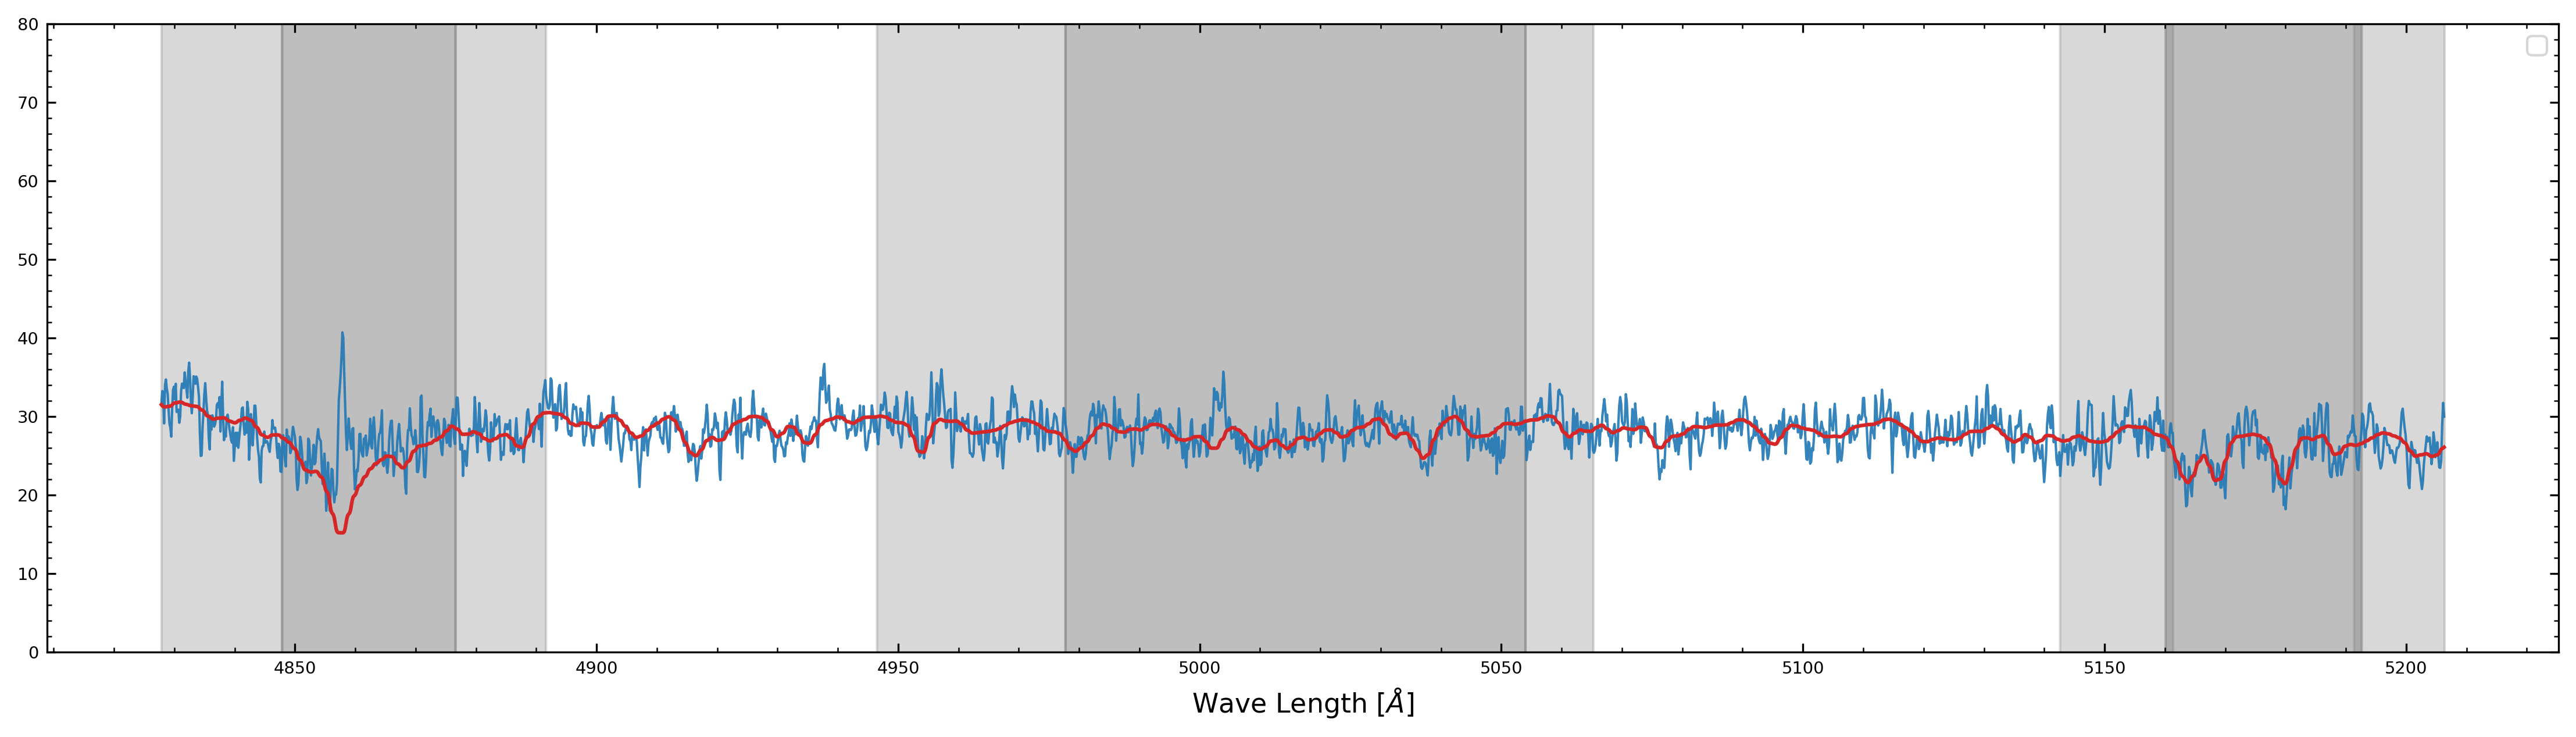

In [206]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal_new,VNB_spectrum_new[:,2], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal_new,Bestfitfield_VNB[:,2], c='tab:red')

for i in Index_use:
    LHS = Index_Wave.loc[i,'CBP_range'][0]
    RHS = Index_Wave.loc[i,'CBP_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5)

for i in Index_use:
    LHS = Index_Wave.loc[i,'BPC_range'][0]
    RHS = Index_Wave.loc[i,'BPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)
for i in Index_use:
    LHS = Index_Wave.loc[i,'RPC_range'][0]
    RHS = Index_Wave.loc[i,'RPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)


ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(0,80)
# ax1.set_xlim(0,1)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

## STF

In [207]:
lam_gal = lam_gal_new

### STF parameters setting

In [208]:
lam_range_gal = [np.min(lam_gal_new), np.max(lam_gal_new)]
gas_templates, gas_names, line_wave = util.emission_lines(sps.ln_lam_temp, lam_range_gal, Galaxy_info.fwhm_gal)

Emission lines included in gas templates:
['Hbeta' '[OIII]5007_d']


In [209]:
ngas_comp = 1   # I use three gas kinematic components
gas_templates = np.tile(gas_templates, ngas_comp)
gas_names = np.asarray([a + f"_({p+1})" for p in range(ngas_comp) for a in gas_names])
line_wave = np.tile(line_wave, ngas_comp)

### Fitting

In [210]:
PP_box = []
for i in tqdm(range(len(VNB[2]))):
        galaxy = VNB_spectrum_new[:,i]
        noise = np.ones_like(galaxy)

        template = optimal_templates_VNB[:,i]
        stars_gas_templates = np.column_stack([template, gas_templates])

        component = [0] + [1]*2
        gas_component=np.array(component) > 0
        moments = [-2, 2]
        ncomp = len(moments)
        tied = [['', ''] for _ in range(ncomp)]

        start = [[velfield_VNB[i], sigfield_VNB[i]],
        [velfield_VNB[i], 50]]
        # start = [[0, 50],
        # [0, 200]]

        vlim = lambda x: velfield_VNB[i] + x*np.array([-100, 100])
        bounds = [[vlim(2), [20, 300]],
                  [vlim(2), [20, 100]]]

        pp = ppxf(stars_gas_templates, galaxy, noise, velscale, start,
            plot=False,
            moments=moments, degree=8, mdegree=-1,
            component=component, 
            gas_component=gas_component, gas_names=gas_names,
            lam=lam_gal_new, lam_temp=sps.lam_temp, tied=tied,
            bounds=bounds,
            global_search=True)
        
        PP_box += [pp]

  0%|          | 0/29 [00:00<?, ?it/s]

differential_evolution step 1: f(x)= 2656.16
differential_evolution step 2: f(x)= 2047.58
differential_evolution step 3: f(x)= 1863.78
differential_evolution step 4: f(x)= 1838.96
differential_evolution step 5: f(x)= 1751.42


  3%|▎         | 1/29 [00:00<00:15,  1.82it/s]

differential_evolution step 6: f(x)= 1750.91
differential_evolution step 7: f(x)= 1750.91
 Best Fit:       Vel     sigma
 comp.  0:      -247        20
 comp.  1:      -249        21
chi2/DOF: 0.7107; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 240
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
       0.9       290      55.9
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      290.3       3.6    -249    21
Comp:  1      [OIII]5007_d_(1)      74.39       4.5    -249    21
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 12511.3
differential_evolution step 2: f(x)= 11004.8
differential_evolution step 3: f(x)= 11004.8
differential_evolution

  7%|▋         | 2/29 [00:01<00:14,  1.90it/s]

differential_evolution step 5: f(x)= 10869.1
differential_evolution step 6: f(x)= 10869.1
 Best Fit:       Vel     sigma
 comp.  0:      -254        20
 comp.  1:      -271        25
chi2/DOF: 4.408; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 210
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
     0.824       866       142
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      865.8       3.7    -271    25
Comp:  1      [OIII]5007_d_(1)      189.0       4.7    -271    25
-----------------------------------------------------------------


 10%|█         | 3/29 [00:01<00:09,  2.69it/s]

differential_evolution step 1: f(x)= 10714.4
 Best Fit:       Vel     sigma
 comp.  0:      -227        20
 comp.  1:      -210        38
chi2/DOF: 4.292; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.877       242      87.4
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      242.4       4.2    -210    38
Comp:  1      [OIII]5007_d_(1)      116.3       5.3    -210    38
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 13581.4
differential_evolution step 2: f(x)= 11107.1
differential_evolution step 3: f(x)= 11107.1
differential_evolution step 4: f(x)= 11107.1
differential_evolution 

 14%|█▍        | 4/29 [00:01<00:10,  2.43it/s]

differential_evolution step 6: f(x)= 11107.1
 Best Fit:       Vel     sigma
 comp.  0:      -245        20
 comp.  1:      -266        29
chi2/DOF: 4.504; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 210
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
      0.92       903       157
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      902.5       3.9    -266    29
Comp:  1      [OIII]5007_d_(1)      209.5       4.9    -266    29
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 11208.3


 17%|█▋        | 5/29 [00:02<00:10,  2.40it/s]

differential_evolution step 2: f(x)= 9458.12
differential_evolution step 3: f(x)= 8823.54
differential_evolution step 4: f(x)= 8796.17
differential_evolution step 5: f(x)= 8774.77
 Best Fit:       Vel     sigma
 comp.  0:      -238        20
 comp.  1:      -221        20
chi2/DOF: 3.567; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 180
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.974       426       103
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      425.8       3.6    -221    20
Comp:  1      [OIII]5007_d_(1)      137.0       4.5    -221    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 6420.33
differential_evolution 

 21%|██        | 6/29 [00:02<00:09,  2.49it/s]

 Best Fit:       Vel     sigma
 comp.  0:      -261        20
 comp.  1:      -264        28
chi2/DOF: 2.372; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      0.93       305      65.8
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      305.4       3.9    -264    28
Comp:  1      [OIII]5007_d_(1)      87.48       4.8    -264    28
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 17998.4
differential_evolution step 2: f(x)= 17212.4


 24%|██▍       | 7/29 [00:02<00:08,  2.47it/s]

differential_evolution step 3: f(x)= 17056.1
differential_evolution step 4: f(x)= 17050.3
differential_evolution step 5: f(x)= 17038.5
 Best Fit:       Vel     sigma
 comp.  0:      -246        20
 comp.  1:      -271        31
chi2/DOF: 6.914; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 180
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
     0.959       766       203
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      766.2       3.9    -271    31
Comp:  1      [OIII]5007_d_(1)      270.4       5.0    -271    31
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 7714.23
differential_evolution step 2: f(x)= 6723.84
differential_evolution

 28%|██▊       | 8/29 [00:03<00:08,  2.57it/s]

 Best Fit:       Vel     sigma
 comp.  0:      -235        20
 comp.  1:      -234        21
chi2/DOF: 2.640; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.961       333      81.9
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      333.1       3.6    -234    21
Comp:  1      [OIII]5007_d_(1)      108.9       4.5    -234    21
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 12102.5


 31%|███       | 9/29 [00:03<00:07,  2.60it/s]

differential_evolution step 2: f(x)= 11554.5
differential_evolution step 3: f(x)= 11554.5
differential_evolution step 4: f(x)= 11543.5
 Best Fit:       Vel     sigma
 comp.  0:      -251        20
 comp.  1:      -269        26
chi2/DOF: 4.672; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.952       550       108
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      549.8       3.8    -269    26
Comp:  1      [OIII]5007_d_(1)      143.0       4.7    -269    26
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 49839.7
differential_evolution step 2: f(x)= 38480.6
differential_evolution

 34%|███▍      | 10/29 [00:04<00:07,  2.42it/s]

differential_evolution step 5: f(x)= 38476.6
differential_evolution step 6: f(x)= 38476.6
 Best Fit:       Vel     sigma
 comp.  0:      -256        20
 comp.  1:      -275        28
chi2/DOF: 15.64; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 210
method = capfit; Jac calls: 2; Func calls: 8; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
     0.987  1.69e+03       579
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      1688.       3.9    -275    28
Comp:  1      [OIII]5007_d_(1)      769.5       4.8    -275    28
-----------------------------------------------------------------


 38%|███▊      | 11/29 [00:04<00:06,  2.97it/s]

differential_evolution step 1: f(x)= 7106.26
 Best Fit:       Vel     sigma
 comp.  0:      -238        20
 comp.  1:      -229        34
chi2/DOF: 2.840; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.951       184        72
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      183.9       4.1    -229    34
Comp:  1      [OIII]5007_d_(1)      95.80       5.1    -229    34
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 23173.3


 41%|████▏     | 12/29 [00:04<00:06,  2.75it/s]

differential_evolution step 2: f(x)= 20334.1
differential_evolution step 3: f(x)= 19916.9
differential_evolution step 4: f(x)= 19855.7
differential_evolution step 5: f(x)= 19853.7
 Best Fit:       Vel     sigma
 comp.  0:      -251        20
 comp.  1:      -259        33
chi2/DOF: 7.979; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 180
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
     0.983       900       168
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      899.9       4.0    -259    33
Comp:  1      [OIII]5007_d_(1)      223.2       5.1    -259    33
-----------------------------------------------------------------


 45%|████▍     | 13/29 [00:05<00:05,  2.94it/s]

differential_evolution step 1: f(x)= 25826.9
differential_evolution step 2: f(x)= 25690.5
differential_evolution step 3: f(x)= 25690.5
 Best Fit:       Vel     sigma
 comp.  0:      -261        20
 comp.  1:      -277        34
chi2/DOF: 10.42; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 120
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.944       573       169
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      573.0       4.1    -277    34
Comp:  1      [OIII]5007_d_(1)      225.3       5.1    -277    34
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 867.223
differential_evolution step 2: f(x)= 789.097
differential_evolution

 48%|████▊     | 14/29 [00:05<00:05,  2.88it/s]

 Best Fit:       Vel     sigma
 comp.  0:      -268        20
 comp.  1:      -277        29
chi2/DOF: 0.3170; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      0.94       139      27.2
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      138.9       3.9    -277    29
Comp:  1      [OIII]5007_d_(1)      36.17       4.9    -277    29
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 10891.2
differential_evolution step 2: f(x)= 8414.75
differential_evolution step 3: f(x)= 7778.63
differential_evolution step 4: f(x)= 7778.63
differential_evolution step 5: f(x)= 7579.4


 52%|█████▏    | 15/29 [00:05<00:05,  2.47it/s]

differential_evolution step 6: f(x)= 7562.58
differential_evolution step 7: f(x)= 7562.58
 Best Fit:       Vel     sigma
 comp.  0:      -246        20
 comp.  1:      -248        25
chi2/DOF: 3.072; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 240
method = capfit; Jac calls: 2; Func calls: 8; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.946       610       129
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      610.4       3.7    -248    25
Comp:  1      [OIII]5007_d_(1)      171.6       4.7    -248    25
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 13109.4
differential_evolution step 2: f(x)= 11250.5
differential_evolution step 3: f(x)= 11250.5
differential_evolution 

 55%|█████▌    | 16/29 [00:06<00:05,  2.30it/s]

differential_evolution step 5: f(x)= 11250.5
differential_evolution step 6: f(x)= 11213.6
 Best Fit:       Vel     sigma
 comp.  0:      -262        20
 comp.  1:      -280        20
chi2/DOF: 4.544; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 210
method = capfit; Jac calls: 2; Func calls: 8; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.955       566       115
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      566.3       3.6    -280    20
Comp:  1      [OIII]5007_d_(1)      153.5       4.5    -280    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 4276.19
differential_evolution step 2: f(x)= 4181.2
differential_evolution step 3: f(x)= 4142.48
differential_evolution s

 59%|█████▊    | 17/29 [00:06<00:04,  2.44it/s]

 Best Fit:       Vel     sigma
 comp.  0:      -268        20
 comp.  1:      -286        24
chi2/DOF: 1.684; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.933       236        56
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      236.1       3.7    -286    24
Comp:  1      [OIII]5007_d_(1)      74.53       4.7    -286    24
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 15934.1
differential_evolution step 2: f(x)= 10077.9
differential_evolution step 3: f(x)= 10077.9
differential_evolution step 4: f(x)= 10077.9
differential_evolution step 5: f(x)= 9975.47


 62%|██████▏   | 18/29 [00:07<00:05,  2.04it/s]

differential_evolution step 6: f(x)= 9975.47
differential_evolution step 7: f(x)= 9916
differential_evolution step 8: f(x)= 9916
differential_evolution step 9: f(x)= 9898.9
 Best Fit:       Vel     sigma
 comp.  0:      -262        20
 comp.  1:      -275        20
chi2/DOF: 4.004; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 300
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      1.01       830       138
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      830.4       3.6    -275    20
Comp:  1      [OIII]5007_d_(1)      183.7       4.5    -275    20
-----------------------------------------------------------------


 66%|██████▌   | 19/29 [00:07<00:03,  2.52it/s]

differential_evolution step 1: f(x)= 2861.14
 Best Fit:       Vel     sigma
 comp.  0:      -268        20
 comp.  1:      -293        20
chi2/DOF: 1.136; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      1.03      90.8      19.2
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      90.79       3.6    -293    20
Comp:  1      [OIII]5007_d_(1)      25.55       4.5    -293    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 5290.29


 69%|██████▉   | 20/29 [00:07<00:03,  2.96it/s]

 Best Fit:       Vel     sigma
 comp.  0:      -274        20
 comp.  1:      -302        20
chi2/DOF: 2.104; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
         1       118      28.8
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      118.4       3.6    -302    20
Comp:  1      [OIII]5007_d_(1)      38.37       4.5    -302    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 22248.9


 72%|███████▏  | 21/29 [00:08<00:02,  3.31it/s]

 Best Fit:       Vel     sigma
 comp.  0:      -284        20
 comp.  1:      -312        71
chi2/DOF: 9.041; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.978       195      4.29
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      194.9       5.4    -312    71
Comp:  1      [OIII]5007_d_(1)      5.707       6.8    -312    71
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1777.54
differential_evolution step 2: f(x)= 1519.47
differential_evolution step 3: f(x)= 1501.39
differential_evolution step 4: f(x)= 1501.39


 76%|███████▌  | 22/29 [00:08<00:02,  2.76it/s]

differential_evolution step 5: f(x)= 1500.96
differential_evolution step 6: f(x)= 1500.53
 Best Fit:       Vel     sigma
 comp.  0:      -287        20
 comp.  1:      -307        20
chi2/DOF: 0.6097; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 210
method = capfit; Jac calls: 2; Func calls: 8; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
         1       181      38.1
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      181.2       3.6    -307    20
Comp:  1      [OIII]5007_d_(1)      50.71       4.5    -307    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1314.72
differential_evolution step 2: f(x)= 1219.2
differential_evolution step 3: f(x)= 1219.2
differential_evolution s

 79%|███████▉  | 23/29 [00:08<00:02,  2.78it/s]

 Best Fit:       Vel     sigma
 comp.  0:      -224        20
 comp.  1:      -211        34
chi2/DOF: 0.4955; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
       0.9       161      53.4
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      161.2       4.1    -211    34
Comp:  1      [OIII]5007_d_(1)      71.01       5.1    -211    34
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 4939.26
differential_evolution step 2: f(x)= 4486.02


 83%|████████▎ | 24/29 [00:09<00:01,  2.79it/s]

differential_evolution step 3: f(x)= 4319.08
differential_evolution step 4: f(x)= 4237.07
 Best Fit:       Vel     sigma
 comp.  0:      -253        20
 comp.  1:      -264        20
chi2/DOF: 1.718; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.918       278      59.5
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      277.8       3.6    -264    20
Comp:  1      [OIII]5007_d_(1)      79.13       4.5    -264    20
-----------------------------------------------------------------


 86%|████████▌ | 25/29 [00:09<00:01,  3.18it/s]

differential_evolution step 1: f(x)= 8500.51
 Best Fit:       Vel     sigma
 comp.  0:      -225        20
 comp.  1:      -235        20
chi2/DOF: 3.243; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.907       239      50.3
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      238.7       3.6    -235    20
Comp:  1      [OIII]5007_d_(1)      66.85       4.5    -235    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 5320.22


 90%|████████▉ | 26/29 [00:09<00:01,  2.99it/s]

differential_evolution step 2: f(x)= 5185.41
differential_evolution step 3: f(x)= 5136.23
differential_evolution step 4: f(x)= 5131.92
 Best Fit:       Vel     sigma
 comp.  0:      -245        20
 comp.  1:      -239        36
chi2/DOF: 2.083; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.922       300      90.8
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      300.0       4.1    -239    36
Comp:  1      [OIII]5007_d_(1)      120.8       5.2    -239    36
-----------------------------------------------------------------


 93%|█████████▎| 27/29 [00:10<00:00,  3.23it/s]

differential_evolution step 1: f(x)= 1826.43
differential_evolution step 2: f(x)= 1800.65
 Best Fit:       Vel     sigma
 comp.  0:      -210        23
 comp.  1:      -204        36
chi2/DOF: 0.7268; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 90
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      0.96       132      32.2
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      132.3       4.1    -204    36
Comp:  1      [OIII]5007_d_(1)      42.78       5.2    -204    36
-----------------------------------------------------------------


100%|██████████| 29/29 [00:10<00:00,  4.06it/s]

differential_evolution step 1: f(x)= 5954.17
 Best Fit:       Vel     sigma
 comp.  0:      -251        20
 comp.  1:      -267        82
chi2/DOF: 2.419; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.686       134      6.61
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      133.7       5.8    -267    82
Comp:  1      [OIII]5007_d_(1)      8.790       7.3    -267    82
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1706.02
 Best Fit:       Vel     sigma
 comp.  0:      -216        20
 comp.  1:      -204        38
chi2/DOF: 0.6914; DOF: 2460; degree = 8; mdegree = 0
Global search

100%|██████████| 29/29 [00:10<00:00,  2.77it/s]


In [211]:
def CK_SpFT(I_index):
    K_index = I_index

    fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,12), dpi=300, tight_layout=True)
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(left=0.05, right=.95, bottom=0.65, top=0.95, hspace=0.0)
    ax1 = plt.subplot(gs1[0])

    gs2 = gridspec.GridSpec(1, 1)
    gs2.update(left=0.05, right=.95, bottom=0.35, top=0.65, hspace=0.0)
    ax2 = plt.subplot(gs2[0])

    gs3 = gridspec.GridSpec(1, 1)
    gs3.update(left=0.05, right=.95, bottom=0.05, top=0.35, hspace=0.0)
    ax3 = plt.subplot(gs3[0])


# -------------------------------------------------------------------------------------------------------------------------------------

    ax1.plot(lam_gal,VNB_spectrum_new[:,I_index], c='tab:blue', lw=1, alpha=.9, label=galaxy_name+'\npixel:[{:}]'.format(I_index))
    ax1.plot(lam_gal,Bestfitfield_VNB[:,I_index], '--', c='tab:red', alpha=.9)

    for i in Index_use:
        LHS = Index_Wave.loc[i,'CBP_range'][0]
        RHS = Index_Wave.loc[i,'CBP_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)

    for i in Index_use:
        LHS = Index_Wave.loc[i,'BPC_range'][0]
        RHS = Index_Wave.loc[i,'BPC_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
    for i in Index_use:
        LHS = Index_Wave.loc[i,'RPC_range'][0]
        RHS = Index_Wave.loc[i,'RPC_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)

    for i in [0]:
        ax1.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:orange', zorder = 1, alpha=.9)

    for i in [1]:
        ax1.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:purple', zorder = 1, alpha=.9)

    ax1.plot(lam_gal,PP_box[K_index].bestfit, '-', lw=.7, c='tab:red')


# -------------------------------------------------------------------------------------------------------------------------------------

    ax2.plot(lam_gal, np.zeros(lam_gal.shape), '-', color='k', lw=.7, alpha=.9, zorder = 0)
    ax2.plot(lam_gal, [np.median(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)]*lam_gal.shape[0], '--', color='tab:blue', lw=1, alpha=.9, zorder = 1)
    MPSig = np.median(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit) + np.std(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)
    MMSig = np.median(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit) - np.std(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)
    ax2.fill([min(lam_gal), max(lam_gal), max(lam_gal), min(lam_gal)], [MPSig, MPSig, MMSig, MMSig], color='tab:gray', alpha=.2,
             label=r'Range:{:1.3f}$\pm${:1.3f}'.format(np.median(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit), np.std(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)), zorder=1)
    ax2.plot(lam_gal, VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit, '+', ms=2, mew=3, color='tab:green', alpha=.9, zorder=2)

# -------------------------------------------------------------------------------------------------------------------------------------

    ax3.plot(lam_gal, VNB_spectrum_new[:,I_index]-Bestfitfield_VNB[:,I_index], '+', ms=2, mew=3, color='tab:green', alpha=.9, zorder=2)
    for i in [0]:
        ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:orange', zorder = 2, alpha=.9)
    for i in [1]:
        ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:purple', zorder = 2, alpha=.9)
    
    ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,0]+PP_box[K_index].gas_bestfit_templates[:,1, ], lw=.7, color='tab:red', zorder = 2, alpha=.9)


# -------------------------------------------------------------------------------------------------------------------------------------


    ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax2.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax3.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    

    ax1.set_xlim(min(lam_gal), max(lam_gal))
    ax2.set_xlim(min(lam_gal), max(lam_gal))
    ax3.set_xlim(min(lam_gal), max(lam_gal))
    ax1.set_ylim(0,max(VNB_spectrum_new[:,I_index])*1.1)
    ax2.set_ylim(min(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)*1.2, max(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)*1.2)
    ax3.set_ylim(min(VNB_spectrum_new[:,I_index]-Bestfitfield_VNB[:,I_index])*1.2, max(VNB_spectrum_new[:,I_index]-Bestfitfield_VNB[:,I_index])*1.2)

    ax3.set_xlabel(r'Wave Length $[\AA]$', size=11)
    
    ax1.legend()
    ax2.legend()
    # ax3.legend()
    plt.show()
    plt.savefig('./../../FitPlot/Fit_08[24Dec17][VCC1588RDBFit]/VNB_res/'+galaxy_name+'Fig[{:}].pdf'.format(K_index), format='pdf', bbox_inches='tight')
    plt.clf()
    plt.close()

    PP_box[K_index] = []

In [212]:
for i in range(len(VNB[6])):
    CK_SpFT(i)

# Data collect

## Spectrum Index

In [213]:
H_Beta_map = np.ndarray(shape=len(VNB[6]))
Fe_5015_map = np.ndarray(shape=len(VNB[6]))
Mg_b_map = np.ndarray(shape=len(VNB[6]))

In [214]:
LP = np.mean([Index_Wave.loc[0,'BPC_range'][0],Index_Wave.loc[0,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[0,'RPC_range'][0],Index_Wave.loc[0,'RPC_range'][1]])

In [215]:
x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))

In [216]:
for i in range(len(VNB[6])):
        
        K_index = i
        spectrum_fit_NEL = PP_box[K_index].bestfit
        for k in [0,1]:
            spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]

        LP = np.mean([Index_Wave.loc[0,'BPC_range'][0],Index_Wave.loc[0,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[0,'RPC_range'][0],Index_Wave.loc[0,'RPC_range'][1]])
        LCB = Index_Wave.loc[0,'CBP_range'][0]
        RCB = Index_Wave.loc[0,'CBP_range'][1]
        LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[0,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[0,'BPC_range'][1])) ])
        RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[0,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[0,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i] = x_wave[:,i] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        NS = y_SL[:,i] - y_spectrum[:,i]
        for k in range(len(y_SL[:,i])):
            NS[k] = NS[k]/y_SL[k,i]

        H_Beta_map[i] = np.trapz(NS, x_wave[:,i])

In [217]:
#Fe 5015

LP = np.mean([Index_Wave.loc[1,'BPC_range'][0],Index_Wave.loc[1,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[1,'RPC_range'][0],Index_Wave.loc[1,'RPC_range'][1]])

In [218]:
#Fe 5015

x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))

In [219]:
#Fe 5015

for i in range(len(VNB[6])):
        
        K_index = i
        spectrum_fit_NEL = PP_box[K_index].bestfit
        for k in [0,1]:
            spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]

        LP = np.mean([Index_Wave.loc[1,'BPC_range'][0],Index_Wave.loc[1,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[1,'RPC_range'][0],Index_Wave.loc[1,'RPC_range'][1]])
        LCB = Index_Wave.loc[1,'CBP_range'][0]
        RCB = Index_Wave.loc[1,'CBP_range'][1]
        LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[1,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[1,'BPC_range'][1])) ])
        RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[1,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[1,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i] = x_wave[:,i] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        NS = y_SL[:,i] - y_spectrum[:,i]
        for k in range(len(y_SL[:,i])):
            NS[k] = NS[k]/y_SL[k,i]

        Fe_5015_map[i] = np.trapz(NS, x_wave[:,i])

In [220]:
#Mg b

LP = np.mean([Index_Wave.loc[2,'BPC_range'][0],Index_Wave.loc[2,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[2,'RPC_range'][0],Index_Wave.loc[2,'RPC_range'][1]])

In [221]:
#Mg b

x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))

In [222]:
#Mg b

for i in range(len(VNB[6])):
        
        K_index = i
        spectrum_fit_NEL = PP_box[K_index].bestfit
        for k in [0,1]:
            spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]


        LP = np.mean([Index_Wave.loc[2,'BPC_range'][0],Index_Wave.loc[2,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[2,'RPC_range'][0],Index_Wave.loc[2,'RPC_range'][1]])
        LCB = Index_Wave.loc[2,'CBP_range'][0]
        RCB = Index_Wave.loc[2,'CBP_range'][1]
        LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[2,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[2,'BPC_range'][1])) ])
        RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[2,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[2,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i] = x_wave[:,i] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        NS = y_SL[:,i] - y_spectrum[:,i]
        for k in range(len(y_SL[:,i])):
            NS[k] = NS[k]/y_SL[k,i]

        Mg_b_map[i] = np.trapz(NS, x_wave[:,i])

## OTP

In [223]:
names = ['Hbeta', '[OIII]5007_d']
c_kms = 299792.458  # speed of light in km/s

In [224]:
VNB_Sol = pd.DataFrame({'H_beta_EL_value':[],'H_beta_EL_ANR':[],
                        'O_3_5007_EL_value':[],'O_3_5007_EL_ANR':[],
                        'Component_Sol':[],
                        'H_beta_SI':[],'Mg_b_SI':[],'Fe_5015_SI':[],
                        'R':[],'SNR':[],'Signal':[],'Noise':[],
                        'K_index':[]})

In [225]:
for Index_num in range(len(VNB[2])):
    K_index = np.where(VNB[0] == Index_num)[0]
    dx = []
    dy = []
    dr = []

    for k_index in K_index:
        i = int(k_index/max(Galaxy_info.col))
        j = k_index%max(Galaxy_info.col)

        Ori_ra  = Galaxy_info.CRVAL1 + ((i)*Galaxy_info.CD1_2) + ((j)*Galaxy_info.CD1_1) + (Galaxy_info.CD1_2+Galaxy_info.CD1_1)/2
        Ori_dec = Galaxy_info.CRVAL2 + ((i)*Galaxy_info.CD2_2) + ((j)*Galaxy_info.CD2_1) + (Galaxy_info.CD2_2+Galaxy_info.CD2_1)/2
        O_x = (Galaxy_info.CRVAL1 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD1_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD1_1))/2)
        O_y = (Galaxy_info.CRVAL2 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD2_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD2_1))/2)
        dx += [Ori_ra - O_x]
        dy += [Ori_dec - O_y]
        dr += [np.sqrt((Ori_ra - O_x)**2 + (Ori_dec - O_y)**2)]
    R = np.mean(dr)

    rms = robust_sigma(VNB_spectrum_new[:,Index_num] - PP_box[Index_num].bestfit, zero=1)
    for p, name in enumerate(names):
        kk = gas_names == name + '_(1)'   # Extract first gas kinematic component
        dlam = line_wave[kk]*Galaxy_info.velscale/c_kms   # Angstrom per pixel at line wavelength (dlam/lam = dv/c)
        flux = (PP_box[Index_num].gas_flux[kk]*dlam)[0]  # Convert to ergs/(cm^2 s)
        an = np.max(PP_box[Index_num].gas_bestfit_templates[:, kk])/rms
        if(kk[0]):
            H_Beta_EL = flux
            H_Beta_EL_AN = an
        if(kk[1]):
            O_5007_EL = flux
            O_5007_EL_AN = an

    S_val = np.mean(VNB_spectrum_new[:,Index_num][ np.where((lam_gal>5075) & (lam_gal<5125)) ]/PP_box[Index_num].bestfit[ np.where((lam_gal>5075) & (lam_gal<5125)) ])
    N_val = np.std(VNB_spectrum_new[:,Index_num][ np.where((lam_gal>5075) & (lam_gal<5125)) ]/PP_box[Index_num].bestfit[ np.where((lam_gal>5075) & (lam_gal<5125)) ])


    VNB_Sol_lim = pd.DataFrame({'H_beta_EL_value':[H_Beta_EL],'H_beta_EL_ANR':[H_Beta_EL_AN],
                        'O_3_5007_EL_value':[O_5007_EL],'O_3_5007_EL_ANR':[O_5007_EL_AN],
                        'Component_Sol':[PP_box[Index_num].sol],
                        'H_beta_SI':[H_Beta_map[Index_num]],'Mg_b_SI':[Fe_5015_map[Index_num]],'Fe_5015_SI':[Mg_b_map[Index_num]],
                        'R':[R],'SNR':[S_val/N_val],'Signal':[S_val],'Noise':[N_val],'K_index':[K_index]})
    VNB_Sol = TB_reindex(pd.concat([VNB_Sol, VNB_Sol_lim]))

In [226]:
VNB_Sol.to_csv('./../FitData/Fit_DS_07[24Dec07][VCC1588]/'+galaxy_name+'_VNB_SFR.csv')